In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')

from data_center.binance_handler import BinanceHandHandler
from backtest.performance_generater import *
from backtest.factor_analysis_tool import FactorAnalysisTool
from backtest.operators import *

import alphalens
import plotly.graph_objects as go

In [3]:
Open = BinanceHandHandler().get_factor_data('open')
High = BinanceHandHandler().get_factor_data('high')
Low  = BinanceHandHandler().get_factor_data('low')
Close = BinanceHandHandler().get_factor_data('close')
Volume = BinanceHandHandler().get_factor_data('volume')
Volvalue = BinanceHandHandler().get_factor_data('volvalue')
Takerbuy = BinanceHandHandler().get_factor_data('takerbuy')
Takerbuyvalue = BinanceHandHandler().get_factor_data('takerbuyvalue')

In [4]:
for column in Open.columns.to_list():
    print(column, Open[column].dropna().index[0])

BTCUSDT 2019-09-08 00:00:00
ETHUSDT 2019-11-27 00:00:00
BNBUSDT 2020-02-10 00:00:00
AAVEUSDT 2020-10-16 00:00:00
AVAXUSDT 2020-09-23 00:00:00
ETCUSDT 2020-01-16 00:00:00
SOLUSDT 2020-09-14 00:00:00
ADAUSDT 2020-01-31 00:00:00
LINKUSDT 2020-01-17 00:00:00
BCHUSDT 2019-12-19 00:00:00
DOTUSDT 2020-08-22 00:00:00
LTCUSDT 2020-01-09 00:00:00
UNIUSDT 2020-09-18 00:00:00
XRPUSDT 2020-01-06 00:00:00
XLMUSDT 2020-01-20 00:00:00
MATICUSDT 2020-10-22 00:00:00
TRXUSDT 2020-01-15 00:00:00
DOGEUSDT 2020-07-10 00:00:00
INJUSDT 2022-08-17 00:00:00
DASHUSDT 2020-02-04 00:00:00
XEMUSDT 2021-03-03 00:00:00
ZECUSDT 2020-02-05 00:00:00


In [5]:
# for Benchmark
returns = Close.pct_change()
expreturn = Close.pct_change().shift(-2)
Benchmark = expreturn['BTCUSDT']
Market = Benchmark.shift(2)

# for alpha research
delete_list = [Open, High, Low, Close, Volume, Volvalue, Takerbuy, Takerbuyvalue]

for target in delete_list:
    del target['BTCUSDT']
    del target['ETHUSDT']
    del target['INJUSDT']
    del target['XEMUSDT']
    target.dropna(inplace=True)

returns = Close.pct_change()
expreturn = Close.pct_change().shift(-2)

### Sharpe Factor

### pleatu

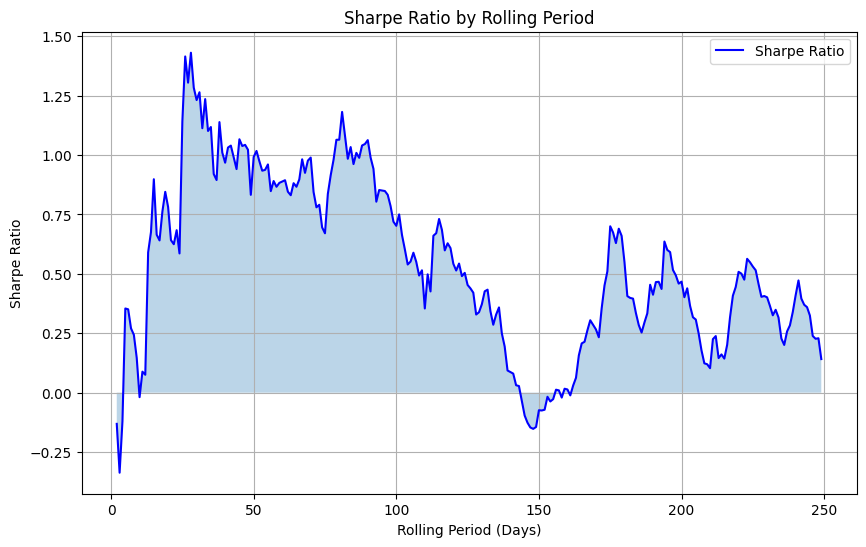

In [8]:
periods = []
sharpes = []

for period in range(2,250,1):
    rolling_returns = returns.rolling(window = period).mean()
    rolling_std_dev = returns.rolling(window = period).std()
    sharpe_factor = rolling_returns / rolling_std_dev
    sharpe_factor = sharpe_factor.dropna()
    returns_by_period = PerformanceGenerator(factor = sharpe_factor, 
                                                expreturn = expreturn,
                                                strategy = 'LS',
                                                buy_fee = 0.04/100,
                                                sell_fee = 0.04/100,
                                                start_time = '2020-01-01',
                                                end_time = '2024-01-19',#'2024-03-19',
                                                period_of_year = 365,
                                                benchmark = Benchmark).get_returns_by_period()
    sharpe = get_sharpe(returns_by_period, 365)
    periods.append(period)
    sharpes.append(sharpe)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(periods, sharpes, label='Sharpe Ratio', color='blue')
plt.fill_between(periods, sharpes, alpha=0.3)
plt.title('Sharpe Ratio by Rolling Period')
plt.xlabel('Rolling Period (Days)')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
period = 25
rolling_returns = returns.rolling(window = period).mean()
rolling_std_dev = returns.rolling(window = period).std()
sharpe_factor = rolling_returns / rolling_std_dev
sharpe_factor = sharpe_factor.dropna()
returns_by_period, _ = PerformanceGenerator(factor = sharpe_factor, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       164.07 %        |       114.98 %       |     0.88     |    22.21 %     |   26.20 %    |  27.07 %   | 1.71 % | 29.07 %  |
|  Benchmark  |       270.91 %        |       201.76 %       |     0.77     |    31.10 %     |   76.67 %    |  54.04 %   | 3.40 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


In [11]:
sharpe_factor_weighting = PerformanceGenerator(factor = sharpe_factor, 
                            expreturn = expreturn,
                            strategy = 'LS',
                            buy_fee = 0.04/100,
                            sell_fee = 0.04/100,
                            start_time = '2020-01-01',
                            end_time = '2024-03-19',
                            period_of_year = 365,
                            benchmark = Benchmark
                            ).get_weighting_by_period()
sharpe_factor_weighting.iloc[-1:]

ETHUSDT   BNBUSDT  AAVEUSDT  AVAXUSDT   ETCUSDT  SOLUSDT  \
datetime                                                                
2024-03-26 -0.013334  0.075796  0.012852   0.06306 -0.017107  0.15944   

             ADAUSDT  LINKUSDT   BCHUSDT   DOTUSDT   LTCUSDT   UNIUSDT  \
datetime                                                                 
2024-03-26 -0.035906 -0.055672  0.037655 -0.002976  0.033393 -0.033739   

             XRPUSDT   XLMUSDT  MATICUSDT  TRXUSDT  DOGEUSDT  DASHUSDT  \
datetime                                                                 
2024-03-26 -0.023274 -0.012708  -0.066726 -0.20703  0.113403  0.004401   

             ZECUSDT  
datetime              
2024-03-26 -0.031526

In [12]:
# FactorAnalysisTool(factor = sharpe_factor, 
#                                             expreturn = expreturn,
#                                             strategy = 'LS',
#                                             buy_fee = 0.04/100,
#                                             sell_fee = 0.04/100,
#                                             start_time = '2020-01-01',
#                                             end_time = '2024-03-19',
#                                             period_of_year = 365,
#                                             benchmark = Benchmark
#                                             ).quantile_analysis(5)

Quantile 5 represents the highest factor value


/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to n

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.497876  0.381235 -0.087655  0.153085   4848  21.053546
2               -0.415361  0.451560 -0.017218  0.151463   4847  21.049203
3               -0.321673  0.478483  0.024411  0.152676   3637  15.794502
4               -0.293996  0.536525  0.073216  0.158982   4847  21.049203
5               -0.276221  0.750693  0.176165  0.174001   4848  21.053546

Returns Analysis


1D      5D     10D
Ann. alpha                                      0.333   0.276   0.213
beta                                            0.010   0.003   0.003
Mean Period Wise Return Top Quantile (bps)     19.956  16.222  12.528
Mean Period Wise Return Bottom Quantile (bps) -11.767  -7.995  -7.781
Mean Period Wise Spread (bps)                  31.723  22.935  19.038

<Figure size 640x480 with 0 Axes>

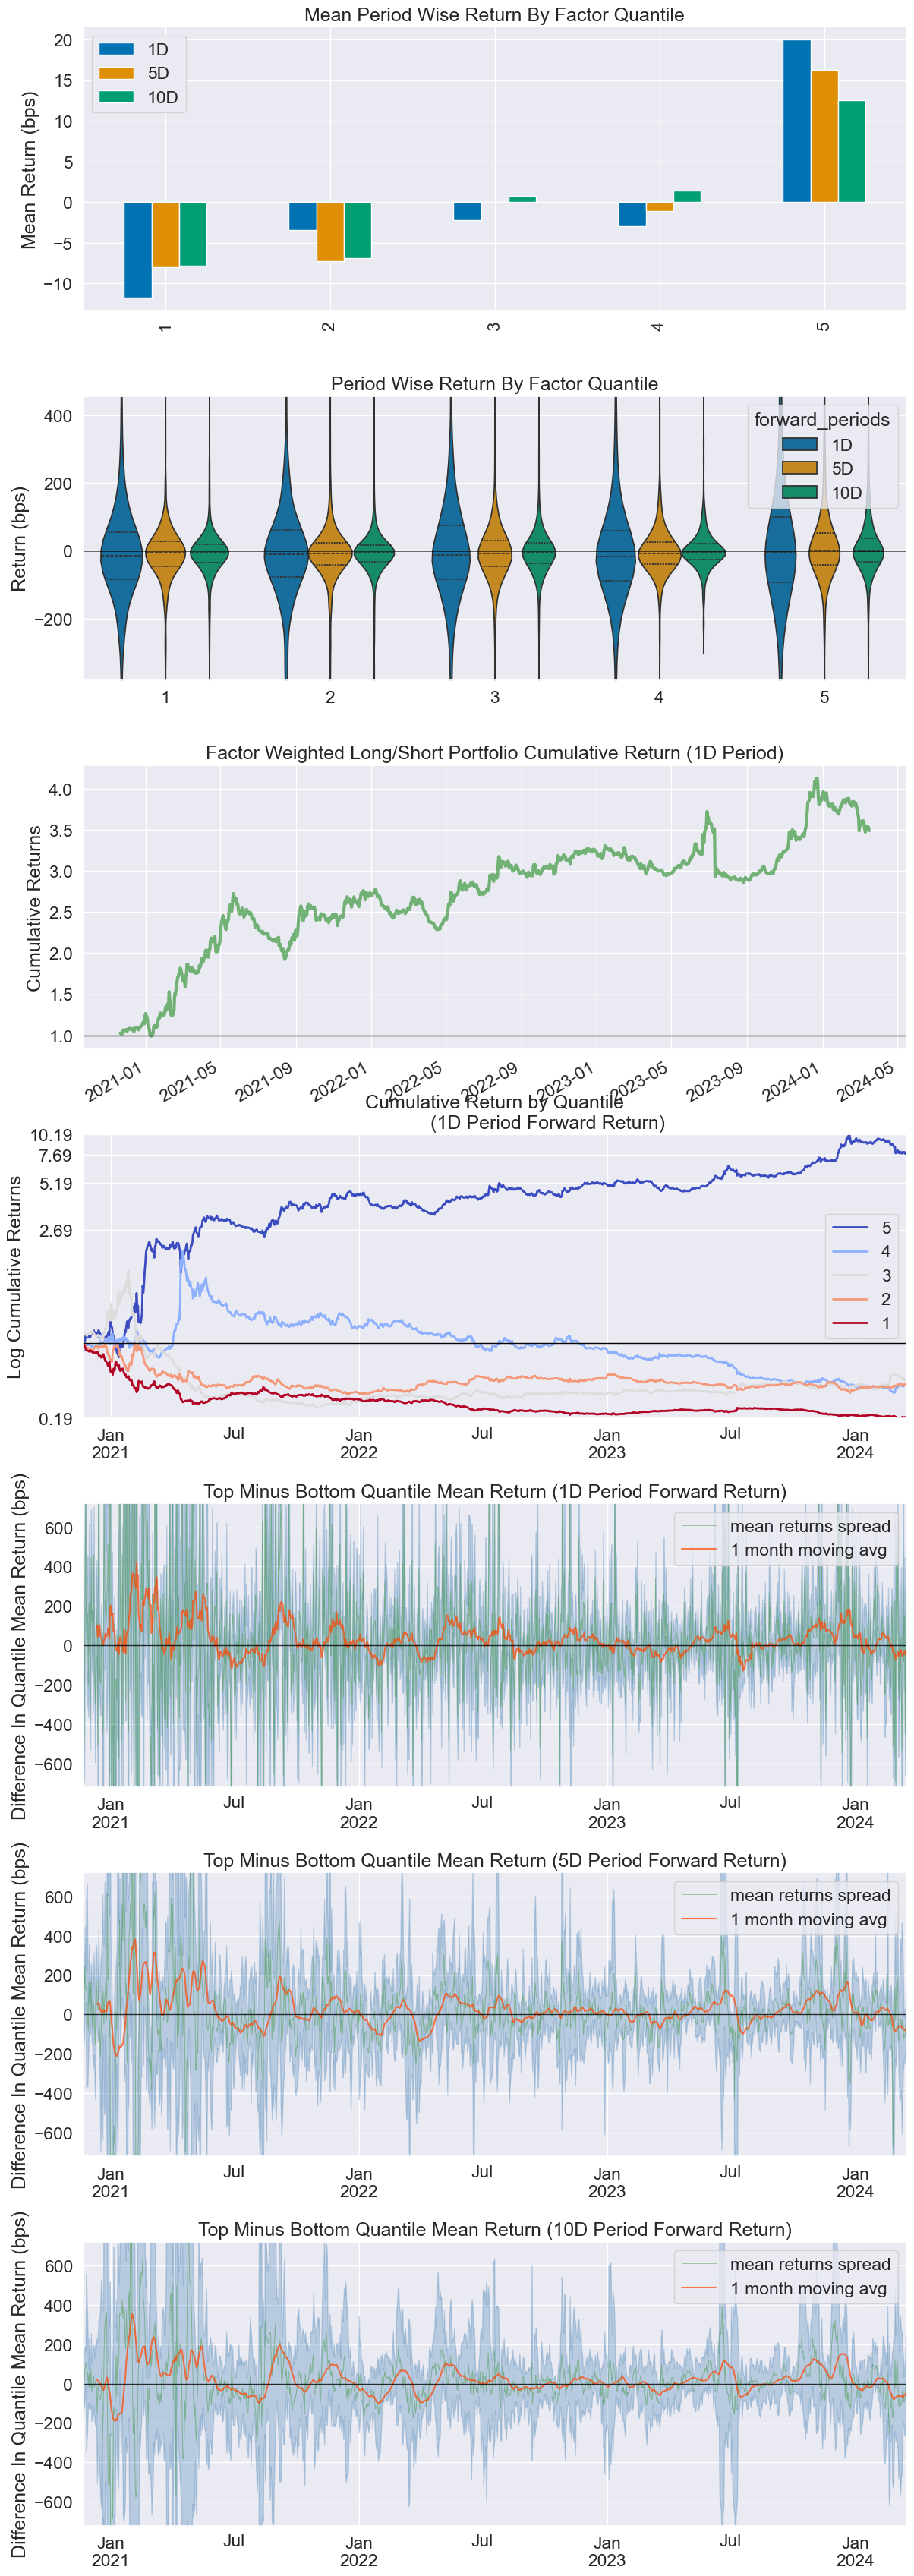

Information Analysis


1D     5D    10D
IC Mean          -0.014 -0.002  0.004
IC Std.           0.283  0.284  0.285
Risk-Adjusted IC -0.048 -0.007  0.013
t-stat(IC)       -1.688 -0.228  0.444
p-value(IC)       0.092  0.820  0.657
IC Skew           0.047  0.058  0.094
IC Kurtosis      -0.469 -0.389 -0.534

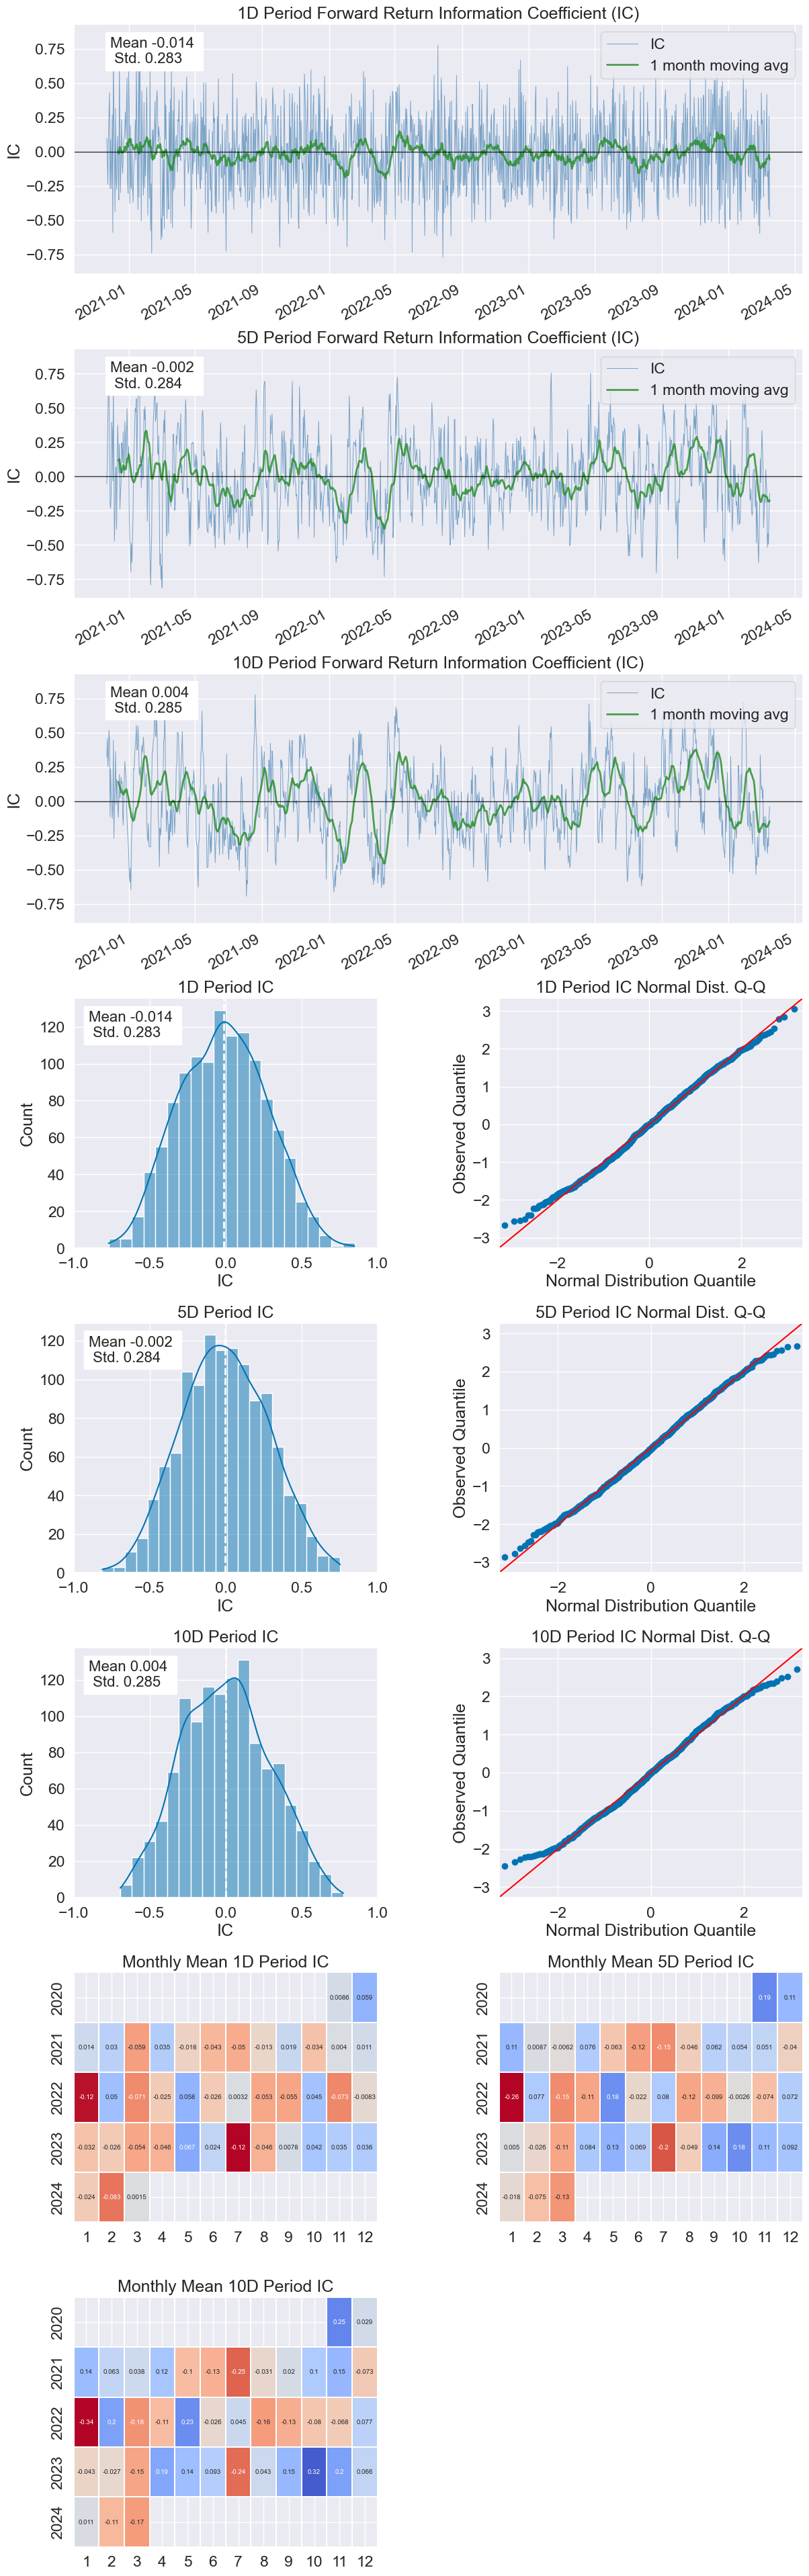

/Users/tedting/anaconda3/envs/quant311/lib/python3.11/site-packages/alphalens/utils.py:929: UserWarning:

Skipping return periods that aren't exact multiples of days.



Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.186  0.381  0.508
Quantile 2 Mean Turnover   0.370  0.592  0.688
Quantile 3 Mean Turnover   0.478  0.695  0.783
Quantile 4 Mean Turnover   0.327  0.570  0.677
Quantile 5 Mean Turnover   0.143  0.308  0.430

1D     5D    10D
Mean Factor Rank Autocorrelation  0.935  0.767  0.593

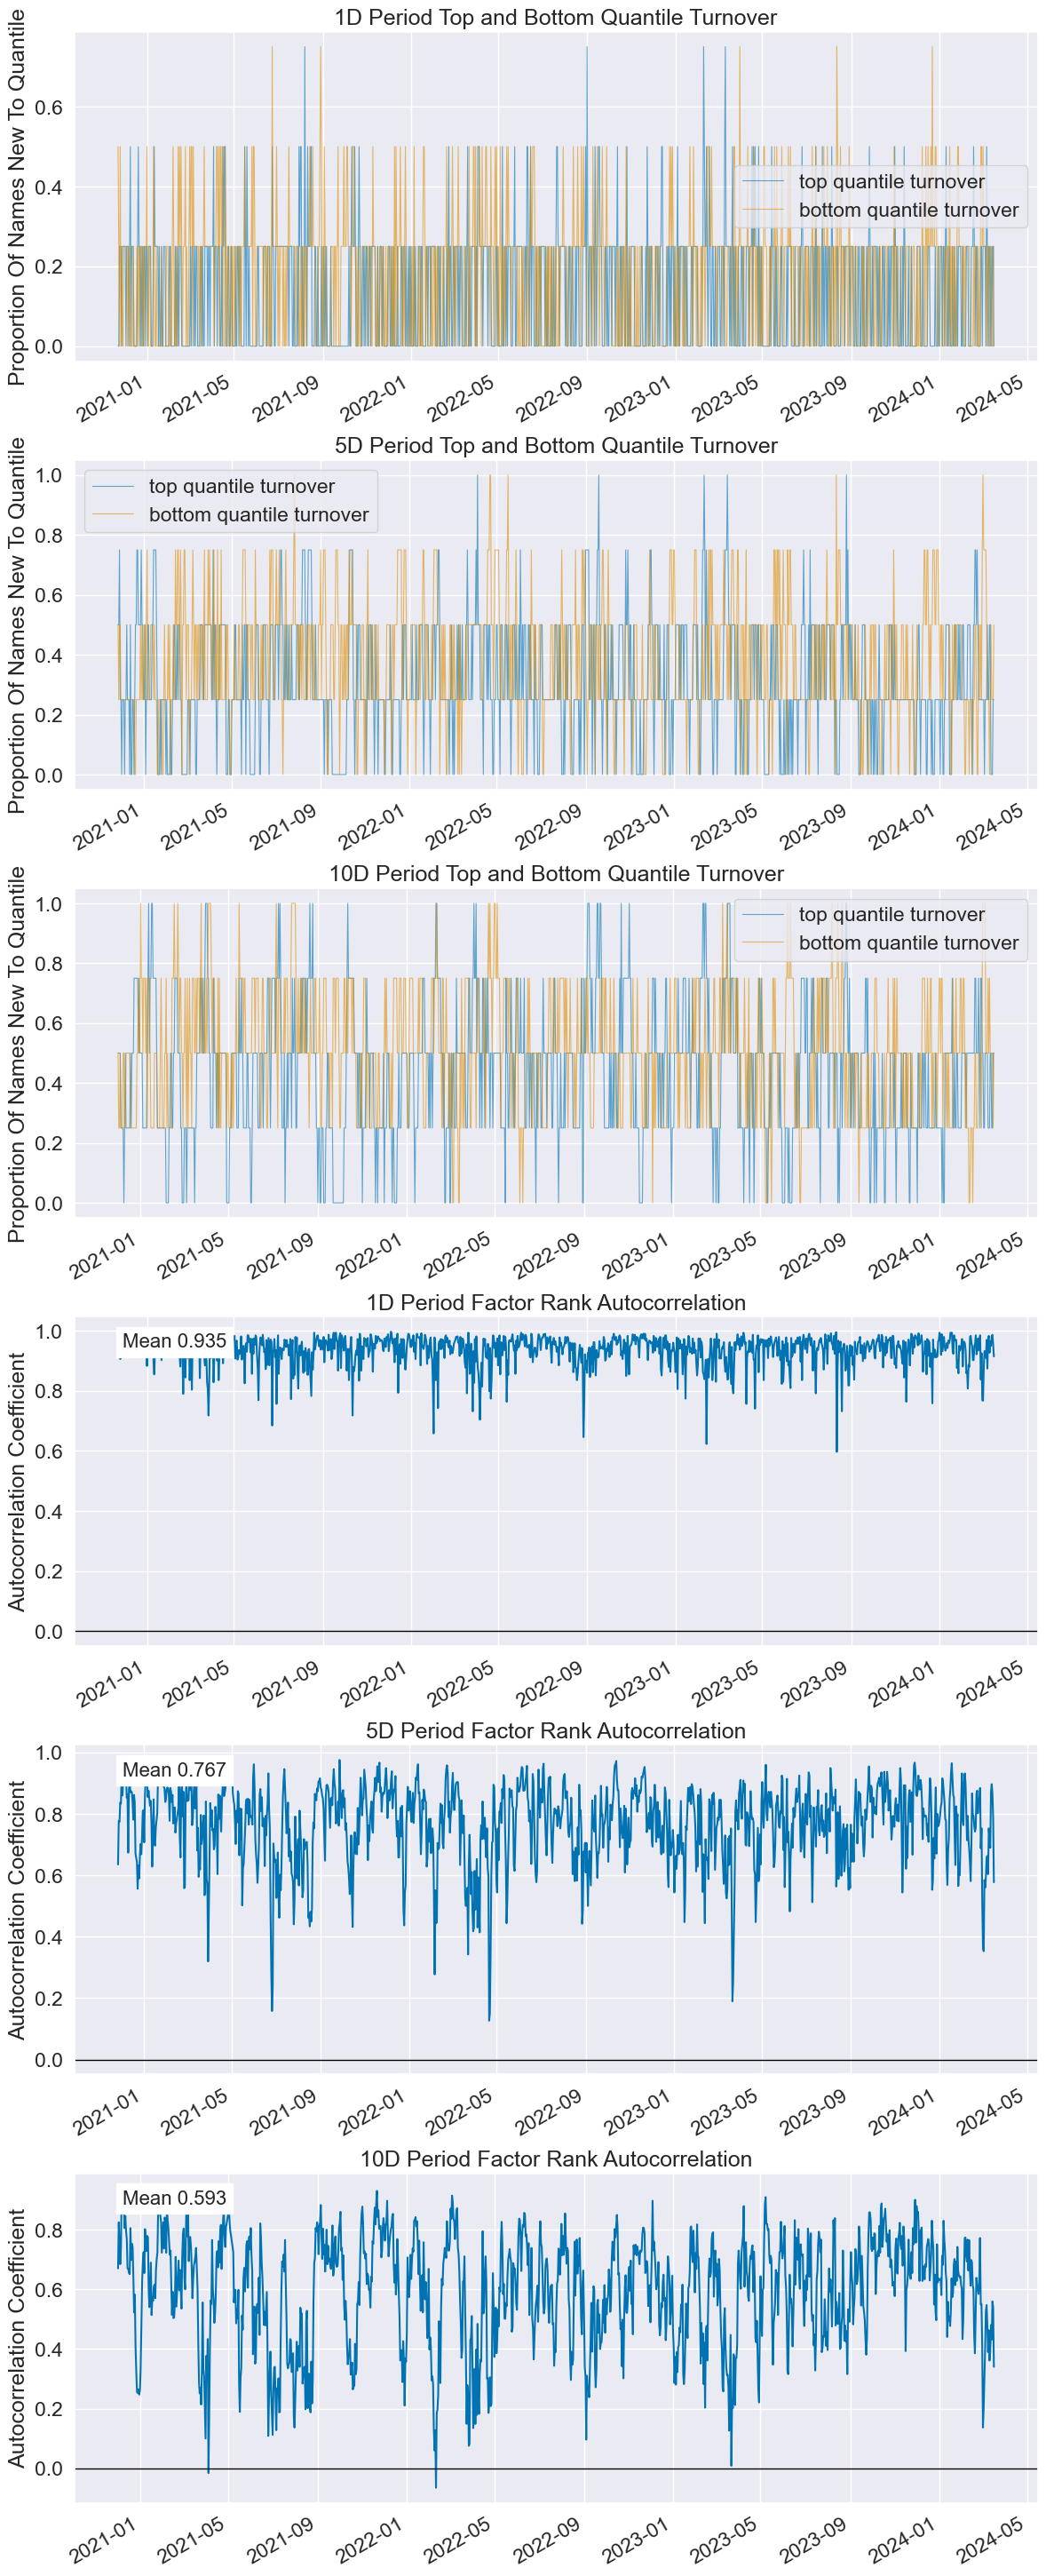

In [13]:
factor = sharpe_factor.dropna()
factor = factor.unstack().swaplevel(i=0, j=1)

factor_daily = factor.sort_index()

close_daily = Close.shift(-1)

# Ingest and format data
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_daily,
                                                                   close_daily,
                                                                   quantiles=5)

# Run analysis
alphalens.tears.create_full_tear_sheet(factor_data)

### Momentum Factor

In [34]:
LogRet= np.log(Close/Close.shift(1))
R_F = LogRet.rolling(window=7).sum().dropna()

returns_by_period, _ = PerformanceGenerator(factor = R_F, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |        64.10 %        |       79.32 %        |     0.46     |    10.61 %     |   30.90 %    |  34.85 %   | 2.20 % | 52.29 %  |
|  Benchmark  |       383.72 %        |       229.51 %       |     0.86     |    37.83 %     |   76.67 %    |  54.10 %   | 3.41 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


### 大盤相關因子

In [39]:
BTCasMarket = pd.DataFrame()# (index=Returns.index, columns=Returns.columns)
# Loop to repeat the concatenation process
for i in returns.columns.to_list():
    BTCasMarket = pd.concat([BTCasMarket, Market.rename(i)], axis=1)
BTCasMarket

ETHUSDT   BNBUSDT  AAVEUSDT  AVAXUSDT   ETCUSDT   SOLUSDT  \
2019-09-08       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-09       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-10 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887   
2019-09-11  0.005695  0.005695  0.005695  0.005695  0.005695  0.005695   
2019-09-12  0.025157  0.025157  0.025157  0.025157  0.025157  0.025157   
...              ...       ...       ...       ...       ...       ...   
2024-03-22 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150   
2024-03-23  0.003044  0.003044  0.003044  0.003044  0.003044  0.003044   
2024-03-24  0.050618  0.050618  0.050618  0.050618  0.050618  0.050618   
2024-03-25  0.039542  0.039542  0.039542  0.039542  0.039542  0.039542   
2024-03-26  0.001768  0.001768  0.001768  0.001768  0.001768  0.001768   

             ADAUSDT  LINKUSDT   BCHUSDT   DOTUSDT   LTCUSDT   UNIUSDT  \
2019-09-08       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-09       NaN       NaN       NaN       NaN       NaN       NaN   
2019-09-10 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887 -0.019887   
2019-09-11  0.005695  0.005695  0.005695  0.005695  0.005695  0.005695   
2019-09-12  0.025157  0.025157  0.025157  0.025157  0.025157  0.025157   
...              ...       ...       ...       ...       ...       ...   
2024-03-22 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150 -0.026150   
2024-03-23  0.003044  0.003044  0.003044  0.003044  0.003044  0.003044   
2024-03-24  0.050618  0.050618  0.050618  0.050618  0.050618  0.050618   
2024-03-25  0.039542  0.039542  0.039542  0.039542  0.039542  0.039542   
2024-03-26  0.001768  0.001768  0.001768  0.001768  0.001768  0.001768   

             XRPUSDT   XLMUSDT  MATICUSDT   TRXUSDT  DOGEUSDT  DASHUSDT  \
2019-09-08       NaN       NaN        NaN       NaN       NaN       NaN   
2019-09-09       NaN       NaN        NaN       NaN       NaN       NaN   
2019-09-10 -0.019887 -0.019887  -0.019887 -0.019887 -0.019887 -0.019887   
2019-09-11  0.005695  0.005695   0.005695  0.005695  0.005695  0.005695   
2019-09-12  0.025157  0.025157   0.025157  0.025157  0.025157  0.025157   
...              ...       ...        ...       ...       ...       ...   
2024-03-22 -0.026150 -0.026150  -0.026150 -0.026150 -0.026150 -0.026150   
2024-03-23  0.003044  0.003044   0.003044  0.003044  0.003044  0.003044   
2024-03-24  0.050618  0.050618   0.050618  0.050618  0.050618  0.050618   
2024-03-25  0.039542  0.039542   0.039542  0.039542  0.039542  0.039542   
2024-03-26  0.001768  0.001768   0.001768  0.001768  0.001768  0.001768   

             ZECUSDT  
2019-09-08       NaN  
2019-09-09       NaN  
2019-09-10 -0.019887  
2019-09-11  0.005695  
2019-09-12  0.025157  
...              ...  
2024-03-22 -0.026150  
2024-03-23  0.003044  
2024-03-24  0.050618  
2024-03-25  0.039542  
2024-03-26  0.001768  

[1662 rows x 19 columns]

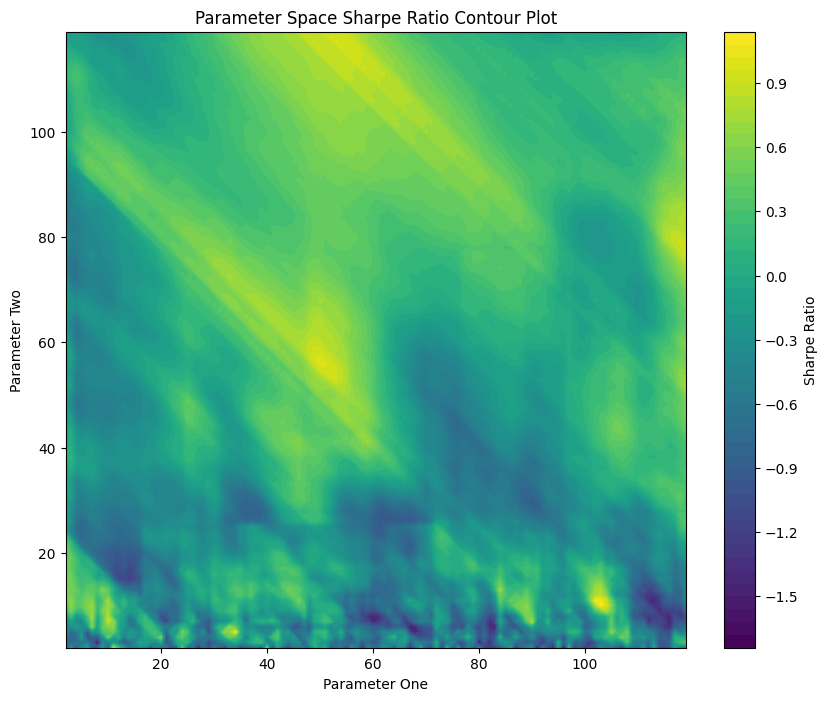

In [44]:
parameter_ones = []
parameter_twos = []
sharpes = []

# 假设参数范围为2到119，对于parameter_one和parameter_two
for parameter_one in range(2, 120):
    for parameter_two in range(2, 120):
        # 计算Market_relate_alpha（此处假设函数调用是正确的）
        Market_relate_alpha = ts_corr(ts_stddev(returns, parameter_one), ts_stddev(BTCasMarket, parameter_one), parameter_two)
        
        # 生成性能数据（此处假设PerformanceGenerator的调用是正确的）
        returns_by_period = PerformanceGenerator(factor = Market_relate_alpha, 
                                                  expreturn = expreturn,
                                                  strategy = 'LS',
                                                  buy_fee = 0.04/100,
                                                  sell_fee = 0.04/100,
                                                  start_time = '2020-01-01',
                                                  end_time = '2024-03-19',
                                                  period_of_year = 365,
                                                  benchmark = Benchmark
                                                  ).get_returns_by_period()
        
        # 计算夏普比率
        sharpe = get_sharpe(returns_by_period, 365)

        parameter_ones.append(parameter_one)
        parameter_twos.append(parameter_two)
        sharpes.append(sharpe)

parameter_ones_array = np.array(parameter_ones)
parameter_twos_array = np.array(parameter_twos)
sharpes_array = np.array(sharpes)

# 创建参数网格
param1_range = np.unique(parameter_ones_array)
param2_range = np.unique(parameter_twos_array)
P1, P2 = np.meshgrid(param1_range, param2_range)

# 创建一个与P1和P2形状相同的网格来存储夏普比率
Sharpe_grid = np.zeros_like(P1, dtype=float)

# 填充夏普比率网格
for i in range(len(sharpes)):
    p1_index = np.where(param1_range == parameter_ones[i])[0][0]
    p2_index = np.where(param2_range == parameter_twos[i])[0][0]
    Sharpe_grid[p2_index, p1_index] = sharpes[i]

# 绘制参数高原图
plt.figure(figsize=(10, 8))
plt.contourf(P1, P2, Sharpe_grid, levels=50, cmap="viridis")
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Parameter One')
plt.ylabel('Parameter Two')
plt.title('Parameter Space Sharpe Ratio Contour Plot')
plt.show()

In [48]:
def mad(df:pd.DataFrame,n:int = 3):
    median=df.median(axis = 1)
    new_median=(df.T - median).T.abs().median(axis = 1)
    up=median+n*new_median
    down=median-n*new_median
    #print(median,up,down)
    return df.clip(down,up,axis=0)

In [59]:
Market_relate_alpha = mad(ts_corr(ts_stddev(returns, 50),ts_stddev(BTCasMarket,50),50),3)
Market_relate_alpha = Market_relate_alpha.dropna()
returns_by_period, _ = PerformanceGenerator(factor = Market_relate_alpha, 
                                            expreturn = expreturn,
                                            strategy = 'LS',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |        47.98 %        |       46.20 %        |     0.58     |     9.00 %     |   25.28 %    |  17.51 %   | 1.10 % |  9.76 %  |
|  Benchmark  |        91.13 %        |       127.81 %       |     0.53     |    15.31 %     |   76.67 %    |  52.66 %   | 3.32 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


In [54]:
Multi_alpha = sharpe_factor + R_F
returns_by_period, _ = PerformanceGenerator(factor = Multi_alpha, 
                                            expreturn = expreturn,
                                            strategy = 'LO',
                                            buy_fee = 0.04/100,
                                            sell_fee = 0.04/100,
                                            start_time = '2020-01-01',
                                            end_time = '2024-03-19',
                                            period_of_year = 365,
                                            benchmark = Benchmark
                                            ).backtest()

+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
|             | Cumprod Total Returns | Cumsum Total Returns | Sharpe Ratio | Annualized Ret | Max Drawdown | Volatility |  STD   | Turnover |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+
| Performance |       480.06 %        |       327.64 %       |     0.84     |    42.74 %     |   74.14 %    |  78.71 %   | 4.96 % | 27.80 %  |
|  Benchmark  |       407.05 %        |       234.38 %       |     0.88     |    38.90 %     |   76.67 %    |  54.01 %   | 3.40 % |   nan    |
+-------------+-----------------------+----------------------+--------------+----------------+--------------+------------+--------+----------+


In [64]:
Market_relate_alpha

ETHUSDT   BNBUSDT  AAVEUSDT  AVAXUSDT   ETCUSDT   SOLUSDT  \
2021-01-29  0.942997  0.727659  0.435361  0.946551  0.775560  0.900784   
2021-01-30  0.943816  0.714301  0.403287  0.946623  0.765511  0.899831   
2021-01-31  0.944544  0.700995  0.413949  0.946341  0.755498  0.898076   
2021-02-01  0.945094  0.709574  0.386280  0.946103  0.744770  0.897087   
2021-02-02  0.945587  0.716654  0.359636  0.945017  0.732385  0.896193   
...              ...       ...       ...       ...       ...       ...   
2024-03-22  0.332378  0.822502  0.735809  0.298293 -0.207364  0.015174   
2024-03-23  0.432972  0.840815  0.759768  0.353827 -0.241836  0.093760   
2024-03-24  0.510393  0.854932  0.780113  0.407026 -0.176983  0.177896   
2024-03-25  0.571119  0.866743  0.796253  0.451558 -0.026767  0.261231   
2024-03-26  0.618881  0.877087  0.810563  0.495796  0.098944  0.349951   

             ADAUSDT  LINKUSDT   BCHUSDT   DOTUSDT   LTCUSDT   UNIUSDT  \
2021-01-29  0.887326  0.968705  0.907130  0.899432  0.588192  0.435361   
2021-01-30  0.882588  0.969813  0.903788  0.899241  0.564577  0.403287   
2021-01-31  0.878603  0.970574  0.900689  0.898419  0.540191  0.413949   
2021-02-01  0.878586  0.971204  0.897622  0.897334  0.508571  0.459622   
2021-02-02  0.877554  0.971211  0.893673  0.895279  0.476318  0.525598   
...              ...       ...       ...       ...       ...       ...   
2024-03-22  0.405141 -0.207364  0.677374  0.087773  0.826751  0.501437   
2024-03-23  0.479154 -0.241836  0.680697  0.158523  0.838449  0.509367   
2024-03-24  0.540839 -0.176983  0.683281  0.233072  0.848402  0.514505   
2024-03-25  0.590498 -0.026767  0.686176  0.309165  0.856087  0.518977   
2024-03-26  0.632658  0.098944  0.689006  0.390538  0.863810  0.521794   

             XRPUSDT   XLMUSDT  MATICUSDT   TRXUSDT  DOGEUSDT  DASHUSDT  \
2021-01-29  0.435361  0.685371   0.925109  0.435361  0.655070  0.810376   
2021-01-30  0.403287  0.671331   0.926959  0.403287  0.670943  0.805352   
2021-01-31  0.413949  0.657311   0.928079  0.413949  0.690774  0.799546   
2021-02-01  0.386280  0.642147   0.928894  0.386280  0.708578  0.793241   
2021-02-02  0.359636  0.624474   0.928992  0.359636  0.726816  0.786653   
...              ...       ...        ...       ...       ...       ...   
2024-03-22  0.817590  0.856953   0.355656  0.265170  0.835942  0.638886   
2024-03-23  0.832130  0.869100   0.429805  0.379025  0.840888  0.668980   
2024-03-24  0.843154  0.878111   0.495381  0.463158  0.845460  0.694916   
2024-03-25  0.851488  0.885234   0.553857  0.527210  0.850068  0.716159   
2024-03-26  0.858757  0.891309   0.606179  0.577998  0.854284  0.736172   

             ZECUSDT  
2021-01-29  0.926809  
2021-01-30  0.926819  
2021-01-31  0.926264  
2021-02-01  0.925529  
2021-02-02  0.924166  
...              ...  
2024-03-22  0.602749  
2024-03-23  0.658448  
2024-03-24  0.700514  
2024-03-25  0.730319  
2024-03-26  0.753809  

[1153 rows x 19 columns]

In [68]:
factor = Multi_alpha.unstack().swaplevel(i=0, j=1)

factor_daily = factor.sort_index()

close_daily = Close.shift(-1)

# Ingest and format data
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_daily,
                                                                   close_daily,
                                                                   quantiles=5)

# Run analysis
alphalens.tears.create_full_tear_sheet(factor_data)

AttributeError: 'MultiIndex' object has no attribute 'tz_localize'

In [ ]:
cufflinks.go_offline()

In [ ]:
import cufflinks
cufflinks.go_offline()
df = returns
df['eq'] = returns.mean(axis =1)

In [ ]:
df['factor'] = returns_by_period

In [ ]:
(returns_by_period - df['eq']/2).cumsum().iplot()

In [ ]:
df.loc['2022-12-23':].cumsum().iplot()

In [ ]:
df.std()

BTCUSDT      0.026261
ETHUSDT      0.030931
BNBUSDT      0.028950
AAVEUSDT     0.042521
AVAXUSDT     0.045632
ETCUSDT      0.041614
SOLUSDT      0.058857
ADAUSDT      0.037514
LINKUSDT     0.041634
BCHUSDT      0.048225
DOTUSDT      0.035996
LTCUSDT      0.037825
UNIUSDT      0.046456
XRPUSDT      0.047193
XLMUSDT      0.041308
MATICUSDT    0.044470
TRXUSDT      0.022147
DOGEUSDT     0.046397
INJUSDT      0.061456
DASHUSDT     0.038647
XEMUSDT      0.043315
ZECUSDT      0.038248
eq           0.031789
factor       0.035158
dtype: float64

TypeError: Axes.hist() missing 1 required positional argument: 'x'

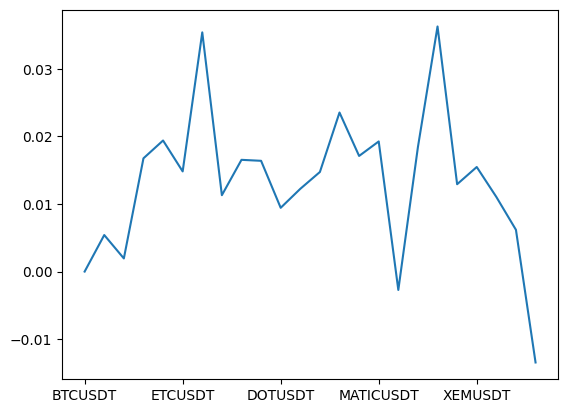

In [ ]:
BTC_std = df.loc[:'2023'].std()['BTCUSDT']
(df.loc[:'2023'].std() - BTC_std).plot().hist()

In [ ]:
# 假設 df 是你的 DataFrame，並且包含到2023年的數據
BTC_std = df.loc[:'2023'].std()['BTCUSDT']

# 計算每個資產相對於BTC的標準差差異
std_diff = df.loc[:'2023'].std() - BTC_std

# 繪製這些標準差差異的直方圖
std_diff.iplot(kind= 'bar')


In [ ]:
# 假設 df 是你的 DataFrame，並且包含到2023年的數據
BTC_std = df.loc['2024':].std()['BTCUSDT']

# 計算每個資產相對於BTC的標準差差異
std_diff = df.loc['2024':].std() - BTC_std

# 繪製這些標準差差異的直方圖
std_diff.iplot(kind= 'bar')